In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from math import pi
from qiskit import *  
import tensorflow as tf
from qutip import *
from sklearn.decomposition import PCA
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from qiskit import IBMQ
backend = Aer.get_backend('qasm_simulator')
#backend = QasmSimulator("statevector_gpu")
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
np.set_printoptions(suppress=True)

plt.style.use("ggplot")

In [2]:
IBMQ.save_account('dfd94226eff0b74bd6a25dc38fc78fccbbfa64d8dc18bb3f07310db5fc8d90e58b256d9cb87b51cc0a2dc6d1d5bff71e33dac772c9f95b5a3baea9725ce39696',overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('simulator_stabilizer')

C:\Users\samue\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [88]:
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255
k=2
pca = PCA(n_components=k)
pca.fit(train_images)
pca_data = pca.transform(train_images)[:10000]
train_labels = train_labels[:10000]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()
pca_data_rot= 2*np.arcsin(np.sqrt(pca_data))
valid_labels = None
valid_labels = train_labels==9
#valid_labels = train_labels == 3 

pca_data_rot = pca_data_rot[valid_labels]
pca_data = pca_data[valid_labels]

print(f"The Total Explained Variance of {k} Dimensions is {sum(pca.explained_variance_ratio_).round(3)}")

reconstruction = pca.inverse_transform(sample_data)
plt.title(f"## DIMENSIONS")
plt.hist(pca_data[:,0])
plt.show()
plt.hist(pca_data[:,1])
plt.show()

The Total Explained Variance of 2 Dimensions is 0.168


NameError: name 'sample_data' is not defined

In [63]:
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

In [64]:
pca_data_rot.shape

(1032, 2)

In [65]:
backend = Aer.get_backend('qasm_simulator')

In [66]:
pca_data_rot.shape

(1032, 2)

# DATA LOADING SECTION -- DEPRECATED 

#  Data Preparation Section

# # These Functions Lead to Qubits Encoding 1 Dimension of Data
## Next Section Is For Dual Qubit Encoding

In [89]:
#All functions needed for the functionality of the circuit simulation
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      dp = np.array((predictions[i] * 127.5) + 127.5).astype('uint8')
      plt.imshow(dp)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    

    
def ran_ang():
    #return np.pi/2
    return np.random.rand()*np.pi

def single_qubit_unitary(circ_ident,qubit_index,values):
    circ_ident.ry(values[0],qubit_index)

def dual_qubit_unitary(circ_ident,qubit_1,qubit_2,values):
    circ_ident.ryy(values[0],qubit_1,qubit_2)

def controlled_dual_qubit_unitary(circ_ident,control_qubit,act_qubit,values):
    circ_ident.cry(values[0],control_qubit,act_qubit)
    #circ_ident.cry(values[0],act_qubit,control_qubit)
    
def traditional_learning_layer(circ_ident,num_qubits,values,style="Dual",qubit_start=1,qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
    elif style =="Single":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
    elif style=="Controlled-Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
        for qub in np.arange(qubit_start,qubit_end-1):
            controlled_dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+"--"+str(qub+1)])

def data_loading_circuit(circ_ident,num_qubits,values,qubit_start=1,qubit_end=5):
    k = 0
    for qub in np.arange(qubit_start,qubit_end):
        circ_ident.ry(values[k],qub)
        k += 1

def swap_test(circ_ident,num_qubits):
    num_swap = num_qubits//2
    for i in range(num_swap):
        circ_ident.cswap(0,i+1,i+num_swap+1)
    circ_ident.h(0)
    circ_ident.measure(0,0)
        
def init_random_variables(q,style):
    trainable_variables = {}
    if style=="Single":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
    elif style=="Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
    elif style=="Controlled-Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
                trainable_variables[str(i)+"--"+str(i+1)] = [ran_ang()]
    return trainable_variables
    
def get_probabilities(circ,counts=5000):
    job = execute(circ, backend, shots=counts)
    results = job.result().get_counts(circ)
    try:
        prob = results['0']/(results['1']+results['0'])
        prob = (prob-0.5)
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob*2
    except:
        prob = 1
    return prob
        
# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value 
# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value 



In [90]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the 
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents 
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
# THIS SECTION IS FOR THE ONLINE GENERATION OF QUANTUM CIRCUITS

def disc_fake_training_circuit(trainable_variables,key,key_value,diff=False,fwd_diff = False,Sample=False):
    if Sample:
        z = q//2
        circ = QuantumCircuit(q,z)
    else:
        circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=q//2 +1,qubit_end=q)
    if Sample:
        for qub in range(q//2):
            circ.measure(q//2 + 1 + qub,qub)
    else:
        swap_test(circ,q)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] += par_shift
    return circ

def disc_real_training_circuit(training_variables,data,key,key_value,diff,fwd_diff):
    circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,training_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    data_loading_circuit(circ,q,data,qubit_start=q//2 +1,qubit_end=q)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] += par_shift
    swap_test(circ,q)
    return circ

def generate_kl_divergence_hist(actual_data, epoch_results_data):
    plt.clf() # clears current figure
    sns.set()
    kl_div_vec = []
    for kl_dim in range(actual_data.shape[1]):
        kl_div = kl_divergence(actual_data[:,kl_dim],epoch_results_data[:,kl_dim])
        kl_div_vec.append(kl_div)
    return kl_div_vec

def bin_data(dataset):
    bins = np.zeros(10)
    for point in dataset:
        indx = int(str(point).split('.')[-1][0]) # The shittest way imaginable to extract the first val aft decimal
        bins[indx] +=1  
    bins /= sum(bins)
    return bins

def kl_divergence(p_dist, q_dist):
    p = bin_data(p_dist)
    q = bin_data(q_dist)
    kldiv = 0
    for p_point,q_point in zip(p,q):
        kldiv += (np.sqrt(p_point) - np.sqrt(q_point))**2
    kldiv = (1/np.sqrt(2))*kldiv**0.5 
    return kldiv
    #return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))  # ?... are we confident in this... 

    
# Checkpointing code
def save_variables(var_dict,epoch):
    with open(f"Epoch-{epoch}-Variables-numbers-9",'w') as file:
        file.write(str(train_var))

In [69]:
# TO LOAD SOME VARs
# DONT RUN UNLESS YOU LOADING VARS.
epoch=50
with open(f"Epoch-{epoch}-Variables-numbers-8-3") as file:
    variables = file.readline()
    train_var = eval(variables)

In [73]:
plt.style.use("ggplot")

Starting Training
--------------------
Generator Loss: 0.3387481961085945
Discriminator Loss: 2.901062298637089
--------------------


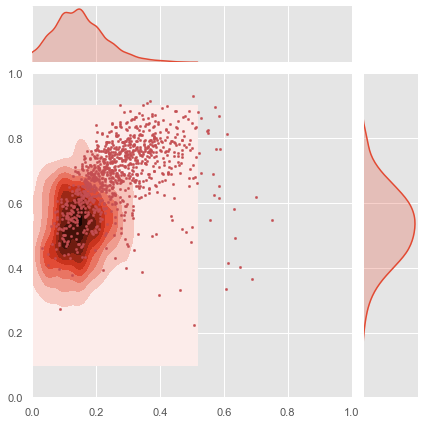

[0.33138616436127727, 0.38613468114969884]
[0.35876042275548803]
Epoch 1 Generated Images


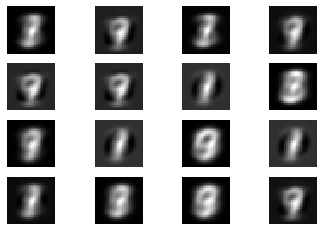

Generator Loss: 0.027704901836881065
Discriminator Loss: 4.383474081720117
--------------------


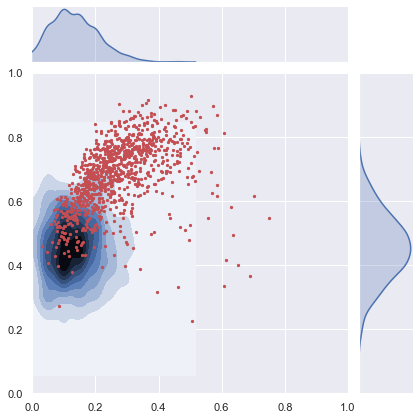

[0.3848948485277606, 0.5842699486912739]
[0.35876042275548803, 0.48458239860951724]
Epoch 2 Generated Images


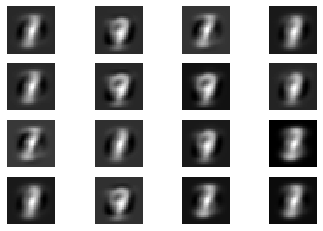

Generator Loss: 0.0042323978905657545
Discriminator Loss: 5.449400755325847
--------------------


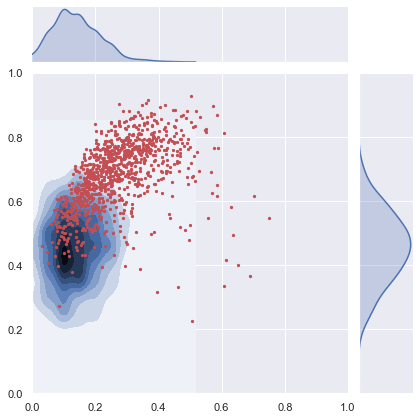

[0.3718798841866436, 0.5764424499793029]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733]
Epoch 3 Generated Images


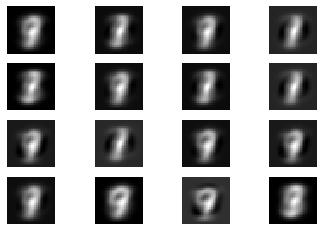

Generator Loss: 0.0013909800629448568
Discriminator Loss: 7.206484817253052
--------------------


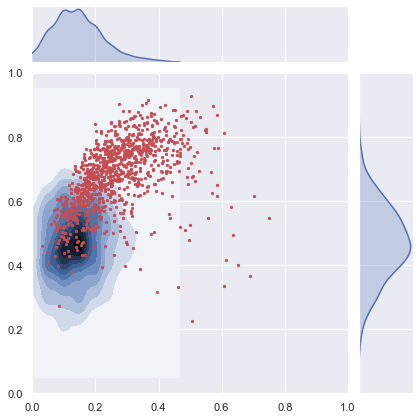

[0.344438501831271, 0.5288664429727428]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069]
Epoch 4 Generated Images


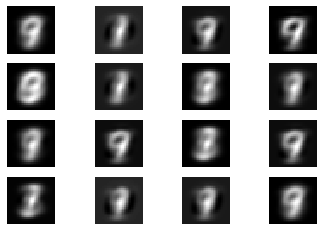

Generator Loss: 0.0007386107873700712
Discriminator Loss: 7.889758554221784
--------------------


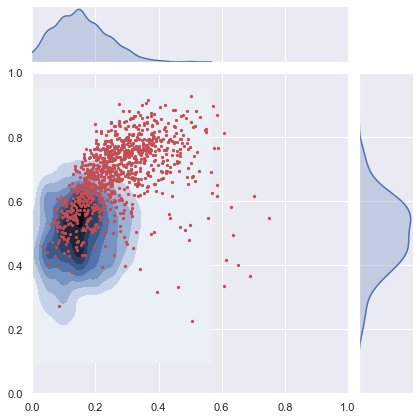

[0.3102237586414773, 0.4702718993176831]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802]
Epoch 5 Generated Images


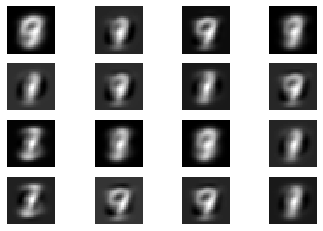

Generator Loss: 0.0009160997197791768
Discriminator Loss: 7.865284758873
--------------------


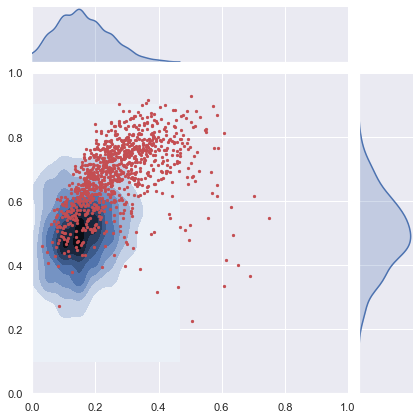

[0.29807489331667375, 0.4466038787230643]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905]
Epoch 6 Generated Images


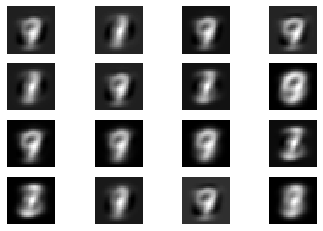

Generator Loss: 0.0014818223093900332
Discriminator Loss: 7.1717208248167115
--------------------


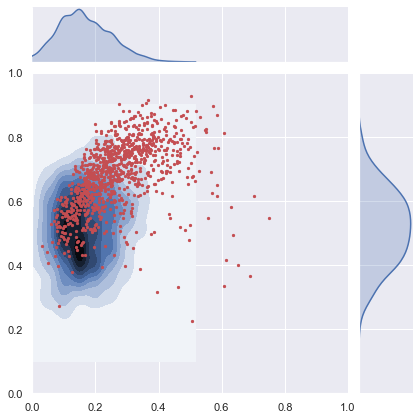

[0.27942718506888276, 0.4101199339626965]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964]
Epoch 7 Generated Images


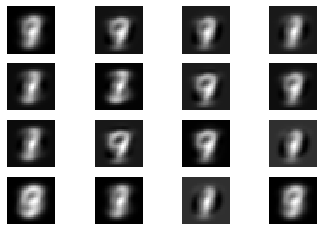

Generator Loss: 0.0017544666534959332
Discriminator Loss: 6.2479580781037445
--------------------


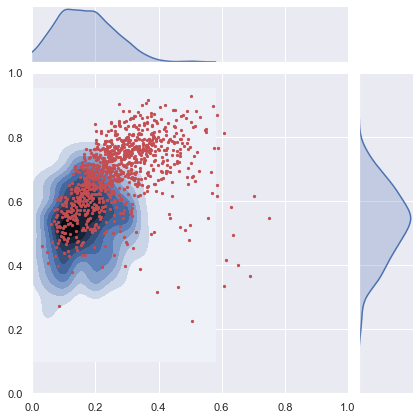

[0.2571688001935436, 0.3855966607670802]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119]
Epoch 8 Generated Images


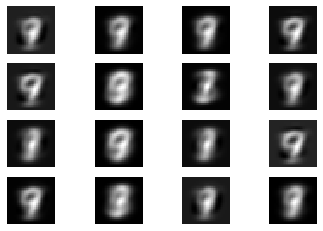

Generator Loss: 0.0020684389934227383
Discriminator Loss: 7.160945751648754
--------------------


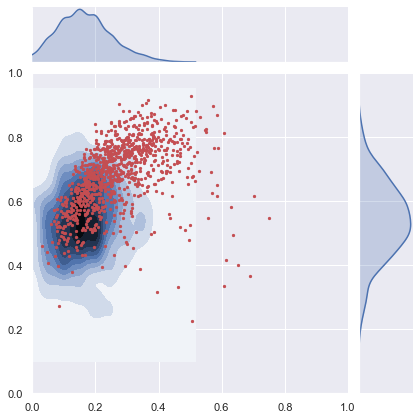

[0.27280795831850724, 0.33746940900973754]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224]
Epoch 9 Generated Images


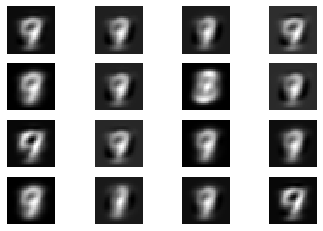

Generator Loss: 0.002498580868233432
Discriminator Loss: 6.751777697527709
--------------------


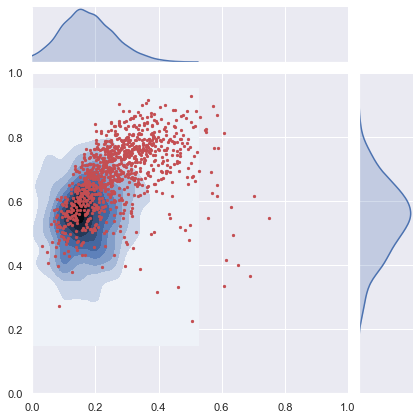

[0.2505518500761586, 0.3375872536570643]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143]
Epoch 10 Generated Images


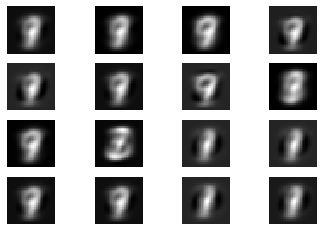

Generator Loss: 0.0026514713489220396
Discriminator Loss: 5.768897161745472
--------------------


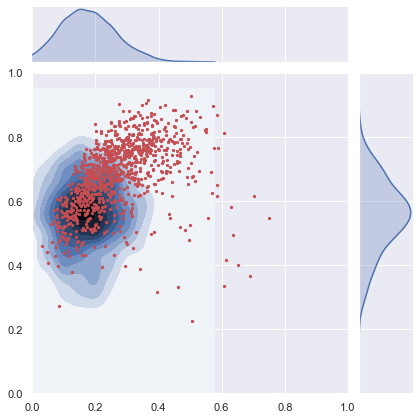

[0.2331147735658761, 0.31169221979929357]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484]
Epoch 11 Generated Images


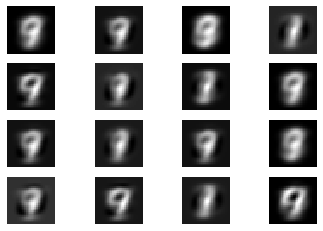

Generator Loss: 0.0025439455799962513
Discriminator Loss: 5.770537851202932
--------------------


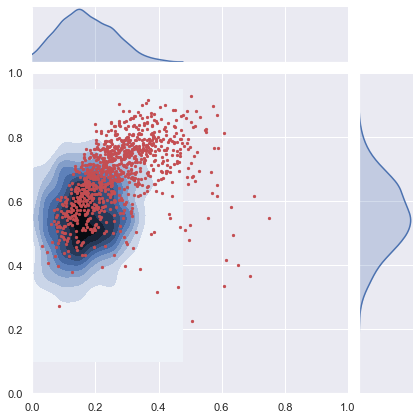

[0.26392865813338773, 0.32875808175887067]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292]
Epoch 12 Generated Images


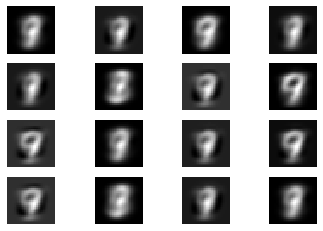

Generator Loss: 0.00294516952908255
Discriminator Loss: 6.048822510268355
--------------------


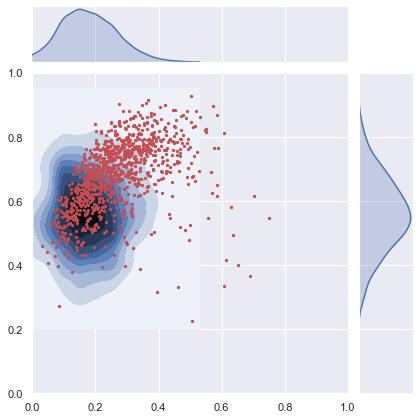

[0.23503553524893703, 0.2987954903049314]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342]
Epoch 13 Generated Images


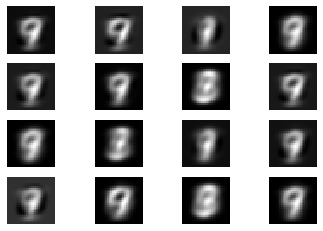

Generator Loss: 0.002767309534041763
Discriminator Loss: 6.746453089412182
--------------------


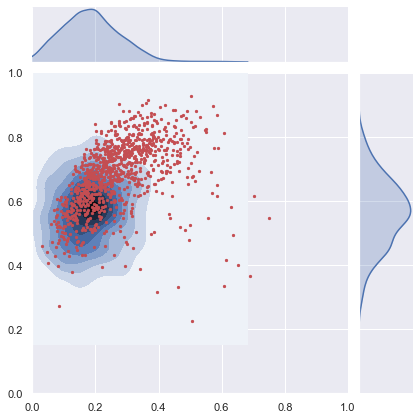

[0.19794022840794184, 0.2936335398873482]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502]
Epoch 14 Generated Images


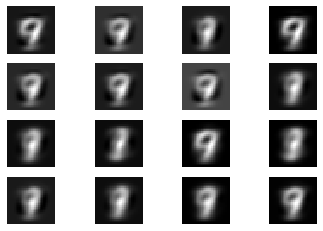

Generator Loss: 0.002618379197422035
Discriminator Loss: 5.356082081798622
--------------------


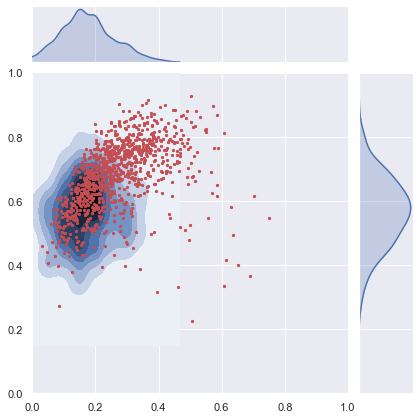

[0.2438195922764064, 0.27856167744765586]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115]
Epoch 15 Generated Images


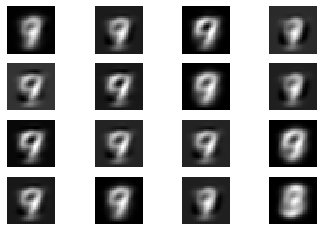

Generator Loss: 0.0025026705039852388
Discriminator Loss: 5.532724110140956
--------------------


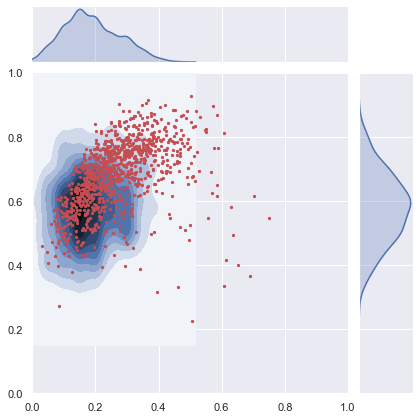

[0.20778192061913783, 0.24064045084991542]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664]
Epoch 16 Generated Images


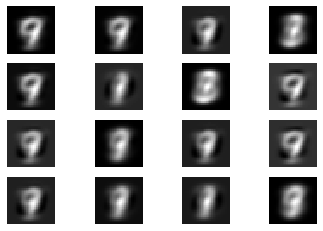

Generator Loss: 0.002622614932017136
Discriminator Loss: 6.0459798687602575
--------------------


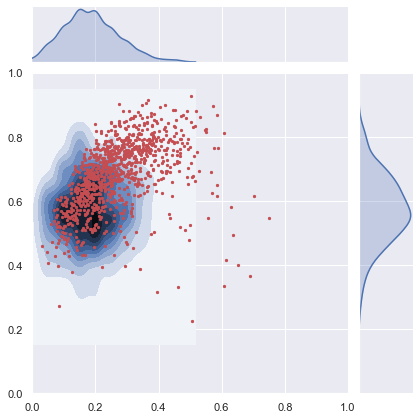

[0.2134104066820494, 0.2659257202639698]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962]
Epoch 17 Generated Images


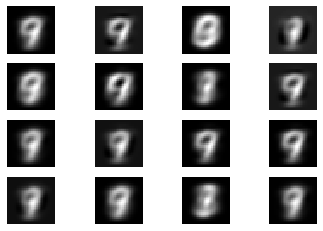

Generator Loss: 0.0024818638814015446
Discriminator Loss: 5.641732046255814
--------------------


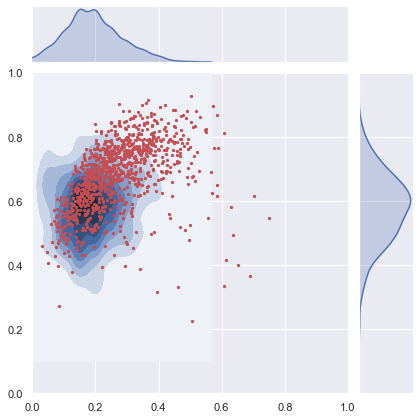

[0.17602332848185356, 0.24423684986297436]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396]
Epoch 18 Generated Images


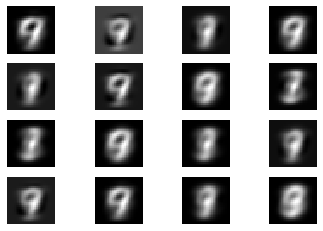

Generator Loss: 0.002295895851632634
Discriminator Loss: 6.227085619933303
--------------------


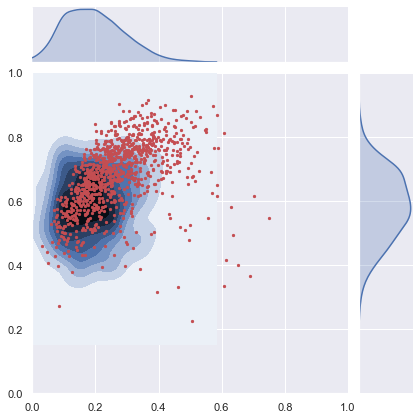

[0.16325948772213794, 0.23397388776829692]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743]
Epoch 19 Generated Images


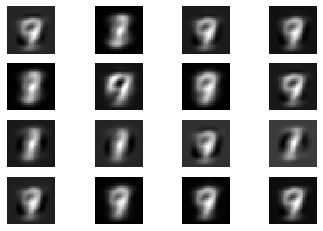

Generator Loss: 0.0022255783676959464
Discriminator Loss: 6.448206107640232
--------------------


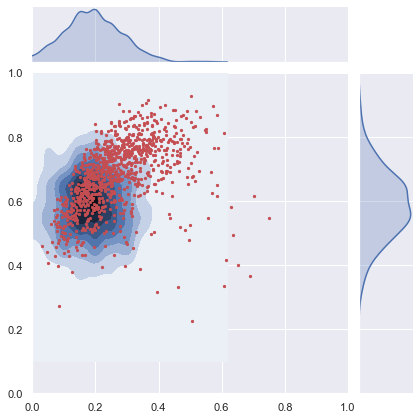

[0.183297174886794, 0.23757686311796047]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724]
Epoch 20 Generated Images


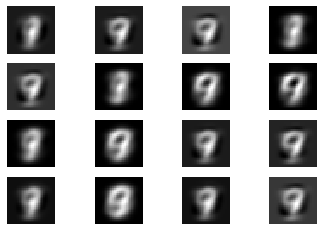

Generator Loss: 0.002002348801673863
Discriminator Loss: 5.635256912341161
--------------------


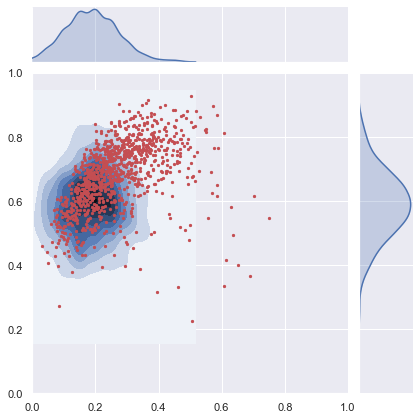

[0.2159956093504838, 0.2297820399534267]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525]
Epoch 21 Generated Images


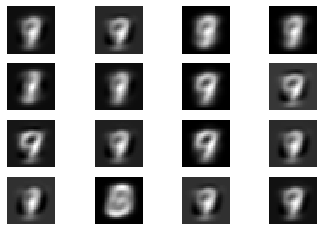

Generator Loss: 0.0020891759143732733
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


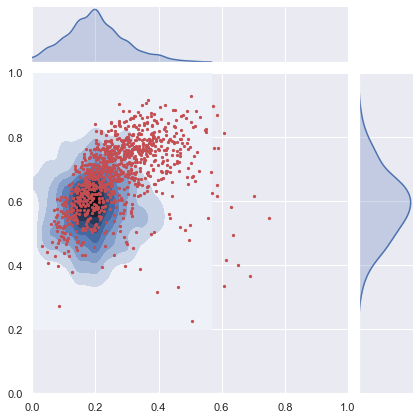

[0.15884566328364458, 0.23765449007975023]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742]
Epoch 22 Generated Images


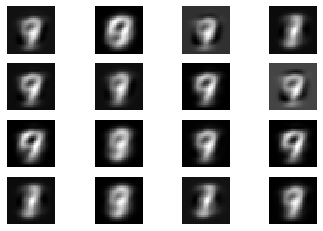

Generator Loss: 0.0019073506351960725
Discriminator Loss: 6.221431323770316
--------------------


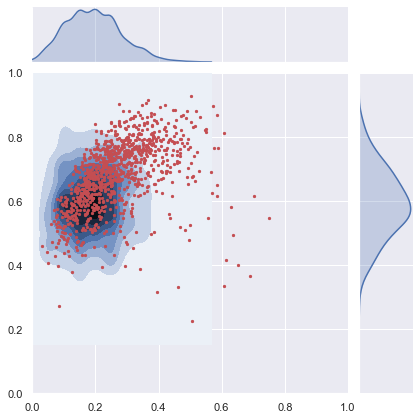

[0.18666939108092218, 0.20980559700799126]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673]
Epoch 23 Generated Images


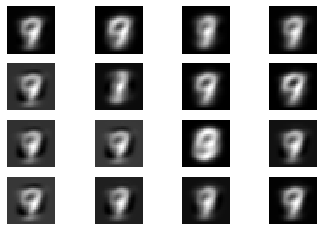

Generator Loss: 0.0017296996087920063
Discriminator Loss: 5.532319661197121
--------------------


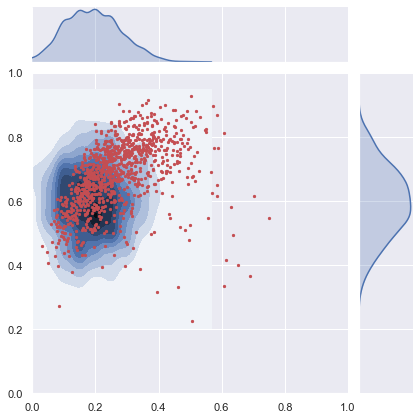

[0.18764595443830465, 0.2042149952523966]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062]
Epoch 24 Generated Images


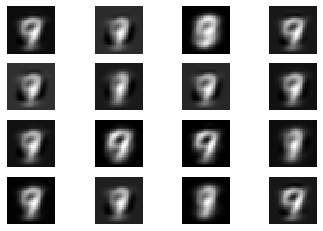

Generator Loss: 0.0016717657823724257
Discriminator Loss: 6.445783821433637
--------------------


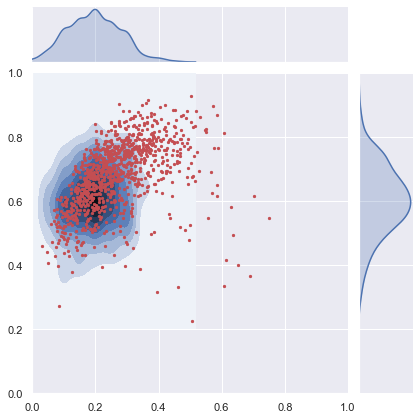

[0.18933616842577092, 0.18213922815567465]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279]
Epoch 25 Generated Images


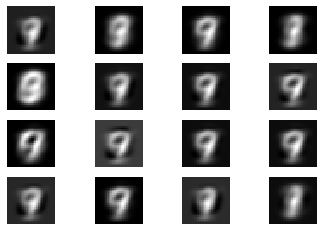

Generator Loss: 0.0015644022861408652
Discriminator Loss: 6.733062749352598
--------------------


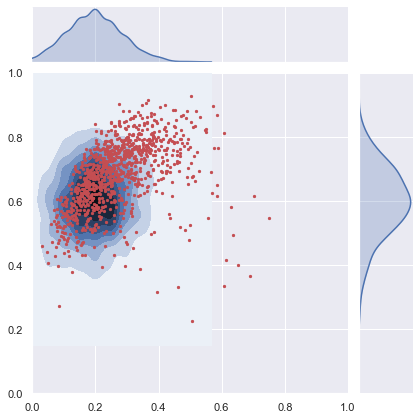

[0.17402733602942053, 0.17574950863778777]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413]
Epoch 26 Generated Images


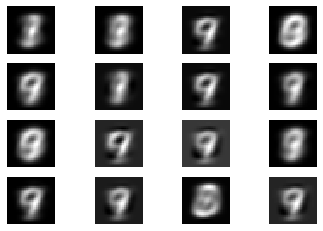

Generator Loss: 0.001283490722645971
Discriminator Loss: 7.832884959523606
--------------------


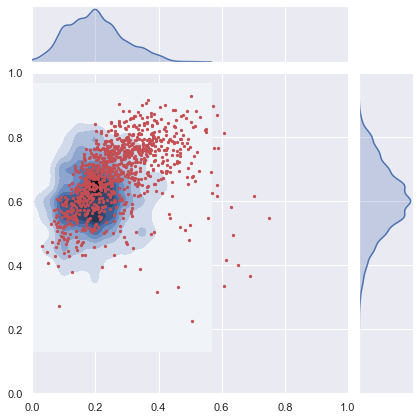

[0.1627996072455057, 0.17202554364349049]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981]
Epoch 27 Generated Images


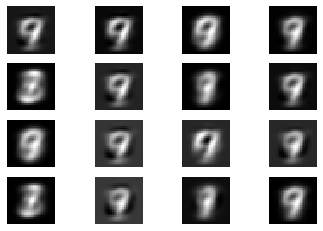

Generator Loss: 0.0015397147080912648
Discriminator Loss: 7.138124875388196
--------------------


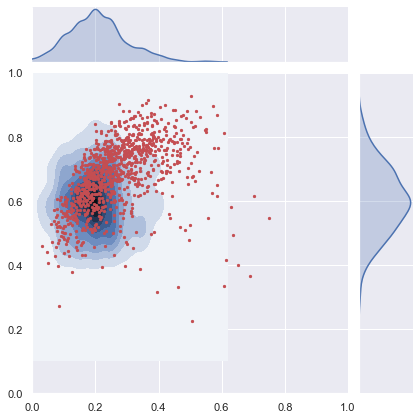

[0.15312489434267373, 0.17794973351805776]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575]
Epoch 28 Generated Images


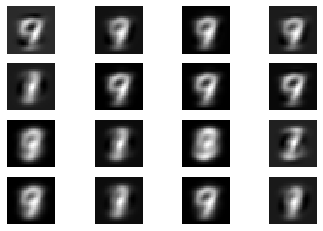

Generator Loss: 0.0012422552829718175
Discriminator Loss: 7.138931001993721
--------------------


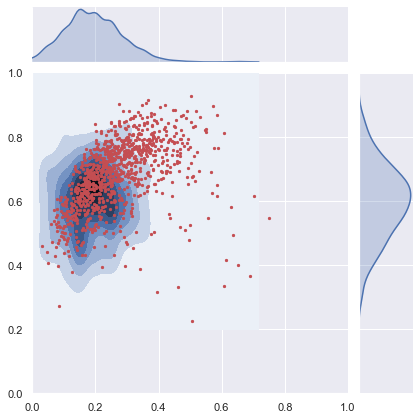

[0.17948287305241908, 0.19319600970052947]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743]
Epoch 29 Generated Images


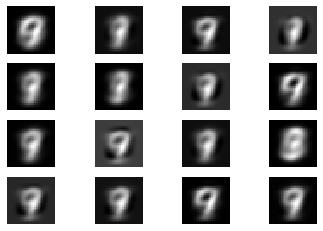

Generator Loss: 0.001122521515228372
Discriminator Loss: 6.219821665475078
--------------------


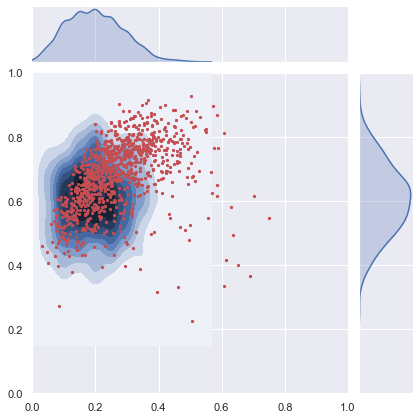

[0.1688952612579797, 0.17649808726378635]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303]
Epoch 30 Generated Images


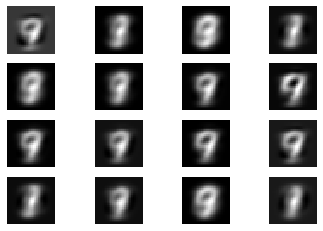

Generator Loss: 0.0010027363750142063
Discriminator Loss: 6.731049460973743
--------------------


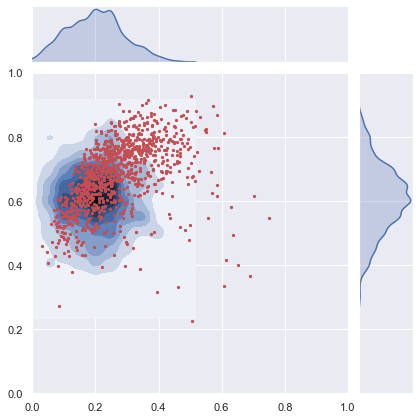

[0.19311704731199095, 0.18124744679805335]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215]
Epoch 31 Generated Images


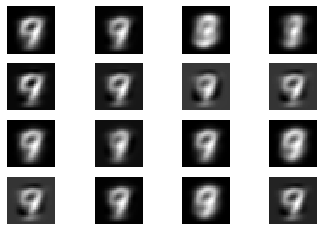

Generator Loss: 0.0009490860245665026
Discriminator Loss: 6.729843430676808
--------------------


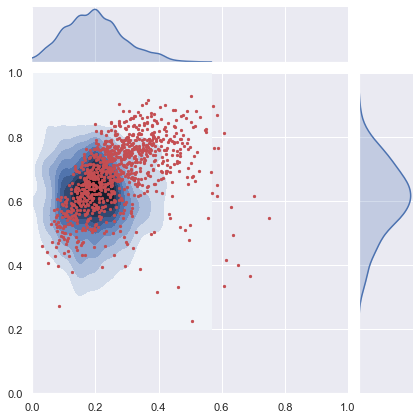

[0.16676543677261613, 0.1552070543853815]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882]
Epoch 32 Generated Images


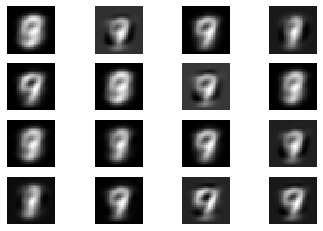

Generator Loss: 0.0009161046483353058
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


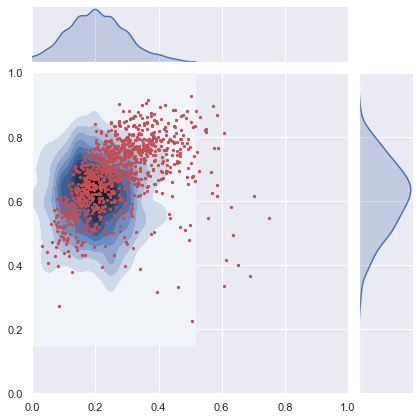

[0.16739999523407123, 0.1373307020876225]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686]
Epoch 33 Generated Images


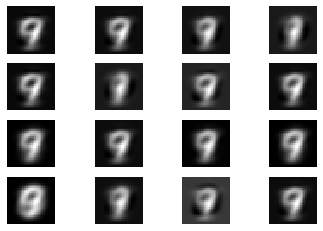

Generator Loss: 0.0007343953602180718
Discriminator Loss: 7.133301714912767
--------------------


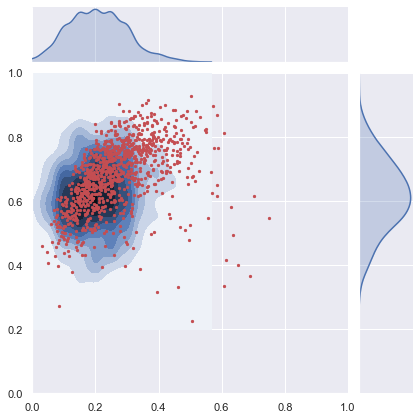

[0.1386324756234353, 0.13881764096370008]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768]
Epoch 34 Generated Images


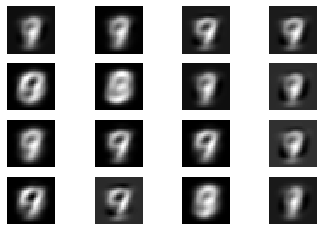

Generator Loss: 0.0008004457549480566
Discriminator Loss: 7.8324814896775035
--------------------


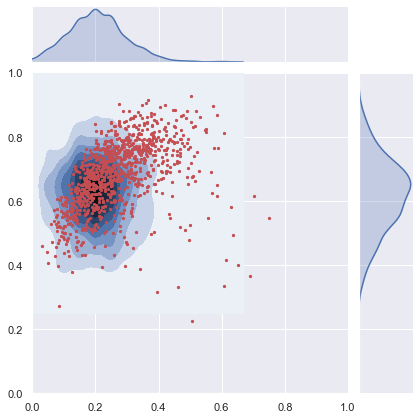

[0.14918492334575592, 0.1290710846828157]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582]
Epoch 35 Generated Images


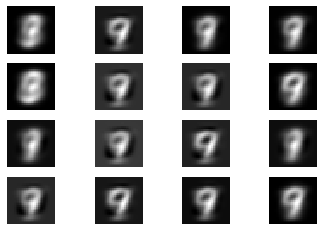

Generator Loss: 0.0007220828945963127
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


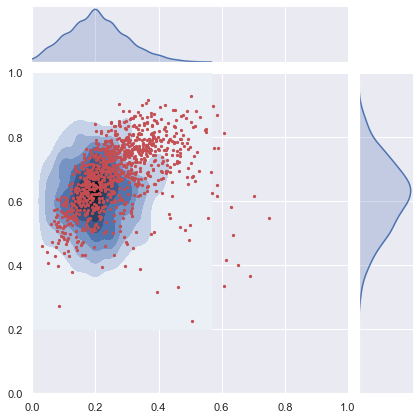

[0.153591449302356, 0.13926341730154468]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035]
Epoch 36 Generated Images


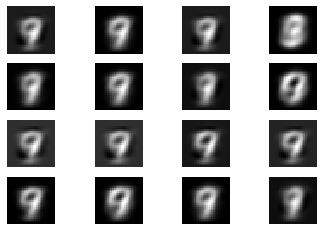

Generator Loss: 0.0007550857736771738
Discriminator Loss: 7.829661749642038
--------------------


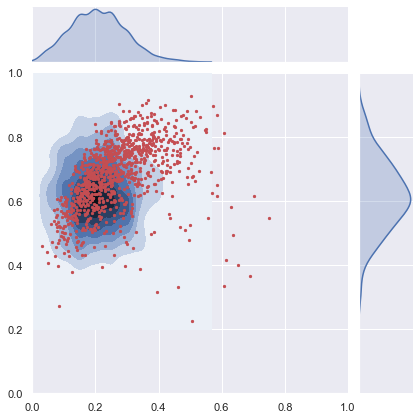

[0.15267321210799142, 0.1379208936822577]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457]
Epoch 37 Generated Images


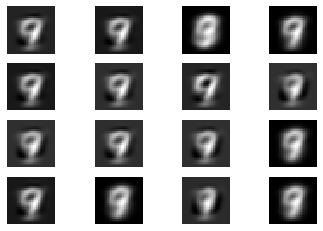

Generator Loss: 0.0007137974870931596
Discriminator Loss: 7.134505325890569
--------------------


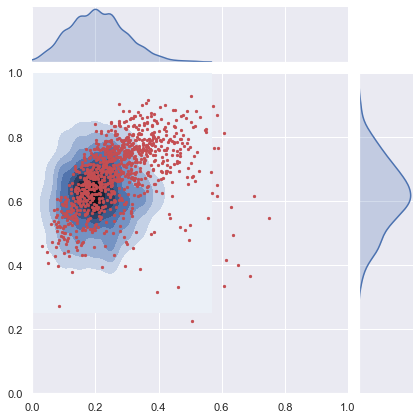

[0.14727056331390748, 0.1377715487553184]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296]
Epoch 38 Generated Images


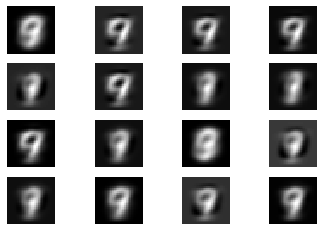

Generator Loss: 0.0006271045601695833
Discriminator Loss: 6.442161358225073
--------------------


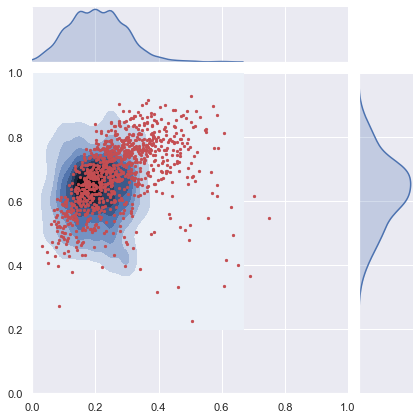

[0.1443685636541374, 0.09906046340733803]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377]
Epoch 39 Generated Images


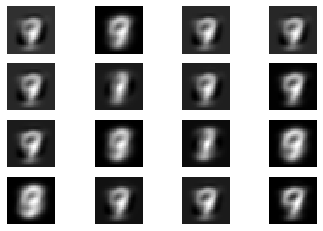

Generator Loss: 0.0005528629358353624
Discriminator Loss: 6.729441743585646
--------------------


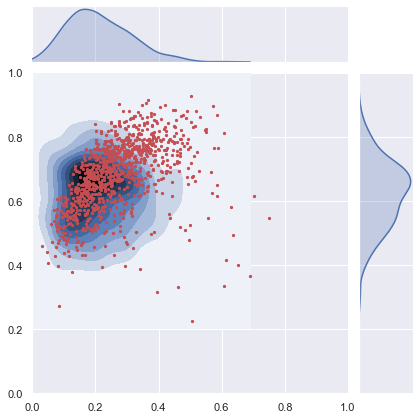

[0.10702797521671305, 0.12657510144959083]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193]
Epoch 40 Generated Images


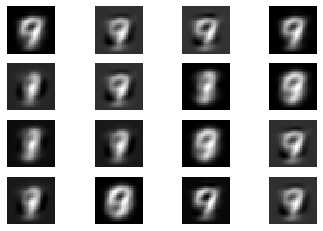

Generator Loss: 0.00047030612467516774
Discriminator Loss: 7.826849938189136
--------------------


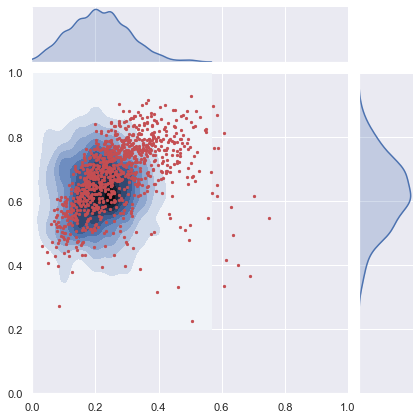

[0.12782240834764713, 0.10342983101923776]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244]
Epoch 41 Generated Images


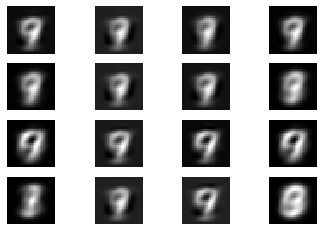

Generator Loss: 0.0004455506396059112
Discriminator Loss: 6.731049460973743
--------------------


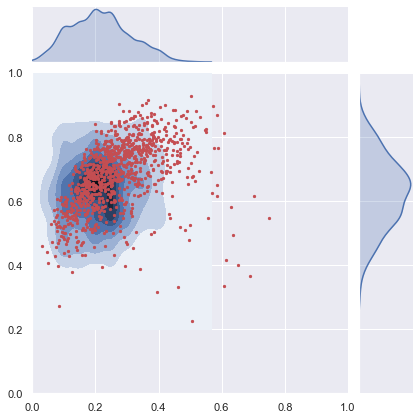

[0.1273822794524355, 0.11871666569604442]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995]
Epoch 42 Generated Images


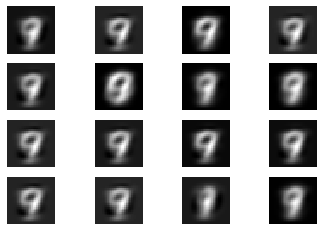

Generator Loss: 0.00037952173047798866
Discriminator Loss: 7.8284557193451025
--------------------


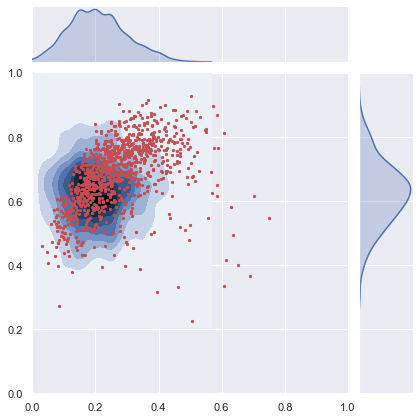

[0.14140773454768737, 0.1351338036270795]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345]
Epoch 43 Generated Images


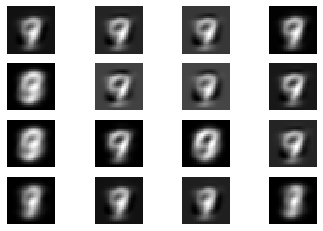

Generator Loss: 0.0004579077351749704
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


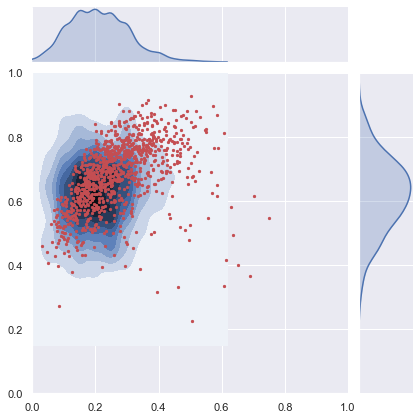

[0.11499095955736845, 0.11891426420926289]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567]
Epoch 44 Generated Images


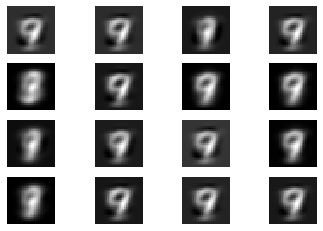

Generator Loss: 0.0003754005023986189
Discriminator Loss: 7.830466578659324
--------------------


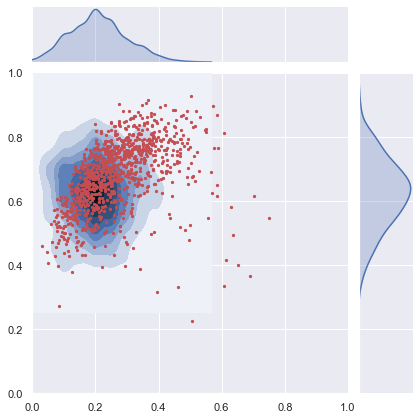

[0.15125448388451534, 0.1197968391785077]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152]
Epoch 45 Generated Ima

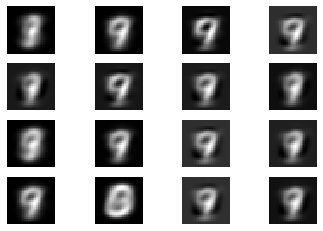

Generator Loss: 0.0003423893481204129
Discriminator Loss: 7.826448895472712
--------------------


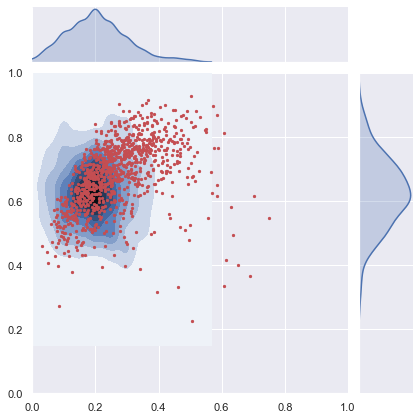

[0.13819033076118192, 0.10987223602174852]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521]


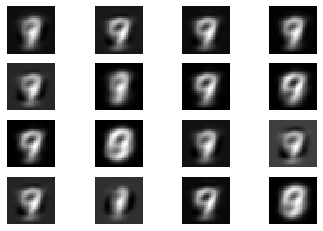

Generator Loss: 0.0003382763740662834
Discriminator Loss: 7.134505325890569
--------------------


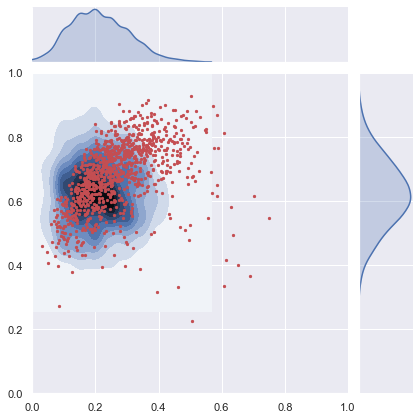

[0.12878485138284224, 0.12850562405164775]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

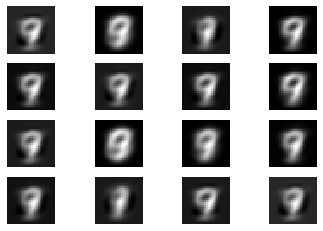

Generator Loss: 0.00033827472590993346
Discriminator Loss: 7.8284557193451025
--------------------


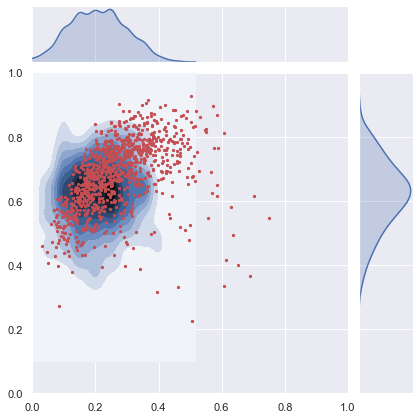

[0.17497670610310143, 0.12530069235994726]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

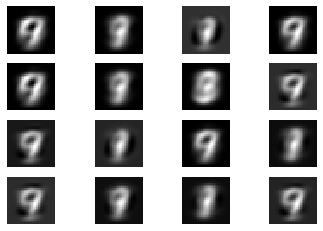

Generator Loss: 0.0002805163511697848
Discriminator Loss: 7.133301714912767
--------------------


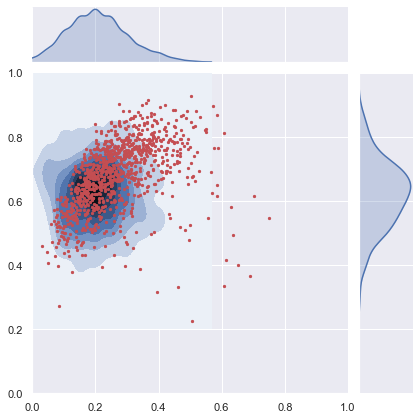

[0.13262808289907585, 0.12695440107908915]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

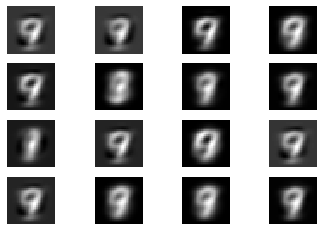

Generator Loss: 0.0002516181775602951
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


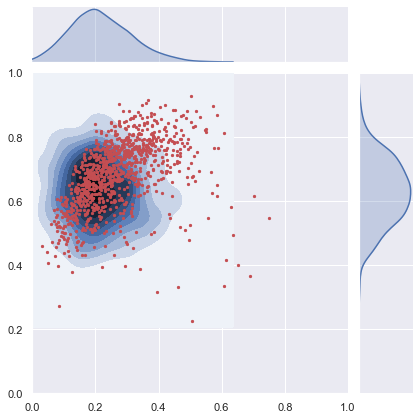

[0.11104682238407212, 0.11528287001316434]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

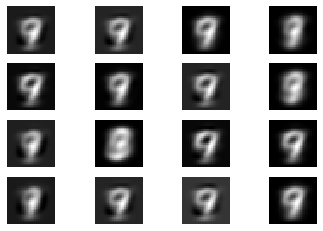

Generator Loss: 0.0001938746693257005
Discriminator Loss: 7.828054032253941
--------------------


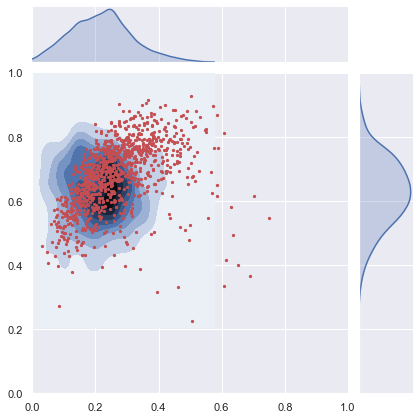

[0.11912552464184453, 0.11410505360085298]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

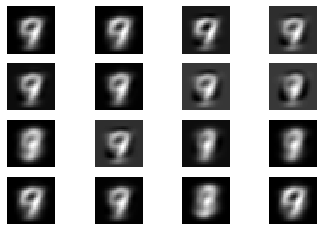

Generator Loss: 0.00022275468011375652
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


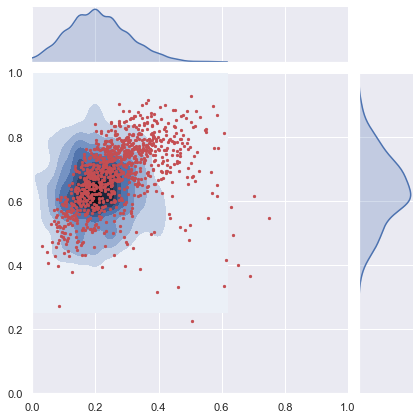

[0.13298740849946644, 0.0972227105708965]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0

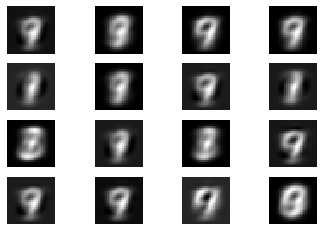

Generator Loss: 0.00024750024712195295
Discriminator Loss: 7.826048013527076
--------------------


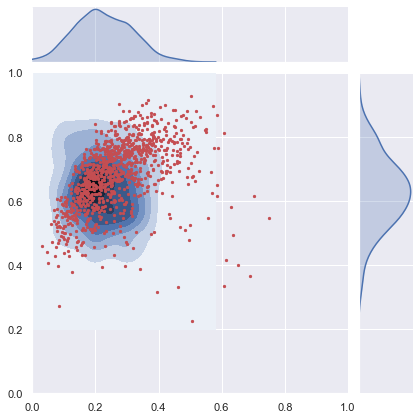

[0.13531492272930945, 0.11564076378613981]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

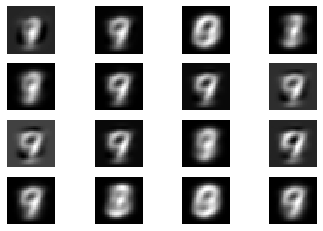

Generator Loss: 0.0002846425501829438
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


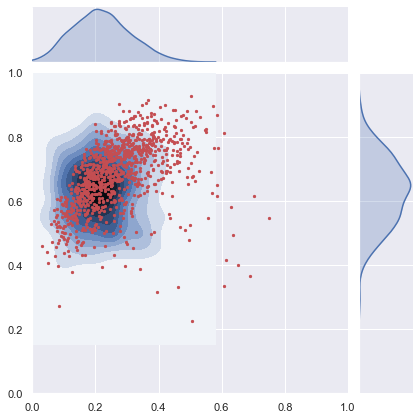

[0.13246860967740348, 0.10973646459186935]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

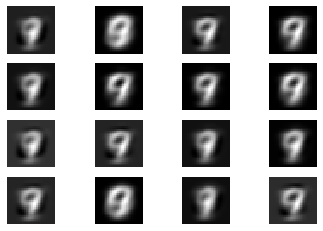

Generator Loss: 0.0001856305531033893
Discriminator Loss: 7.82725114180535
--------------------


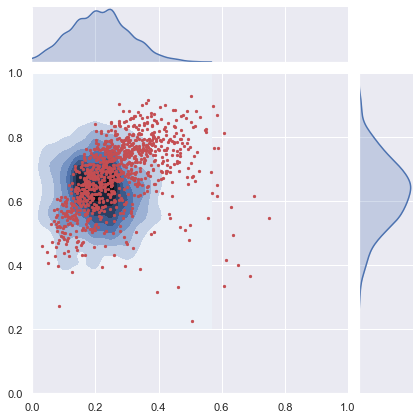

[0.14318253294601085, 0.11888503224498911]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

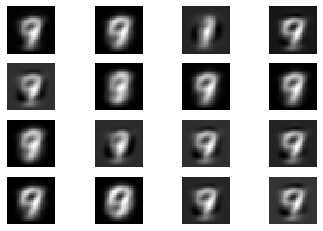

Generator Loss: 0.0001608684714317071
Discriminator Loss: 7.828054032253941
--------------------


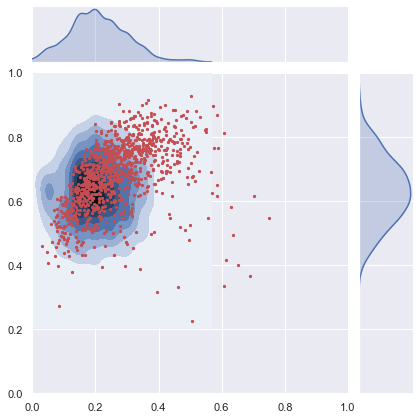

[0.1464117880854917, 0.10958195977181613]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0

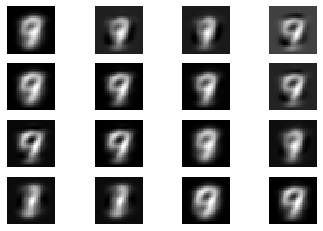

Generator Loss: 0.00016499465853922623
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


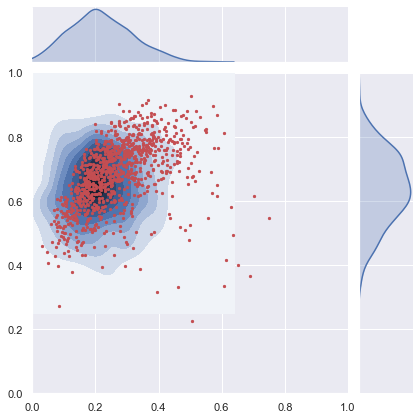

[0.112844348015317, 0.07492908697044247]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0.

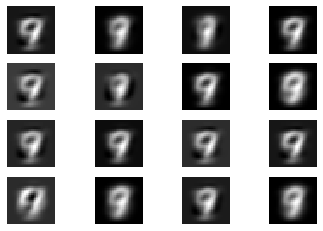

Generator Loss: 0.00016499465986119453
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


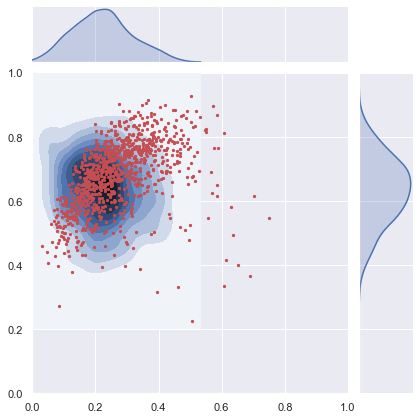

[0.147419161392438, 0.08576112291016734]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0.

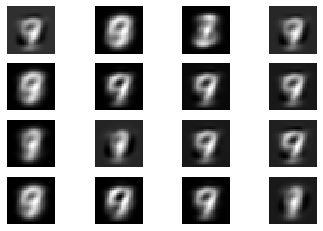

Generator Loss: 0.00016499465986119453
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


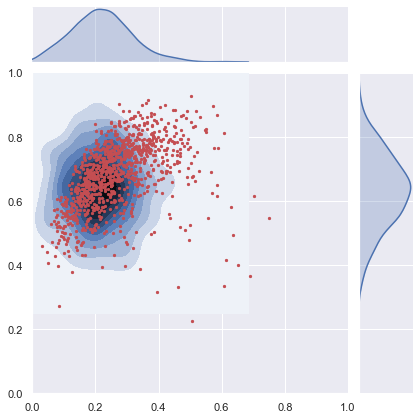

[0.11851176567733432, 0.10053902590027176]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

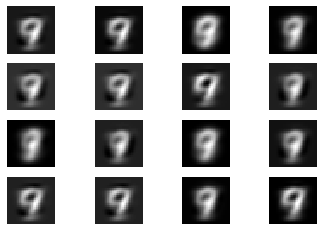

Generator Loss: 0.00011137403712402293
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


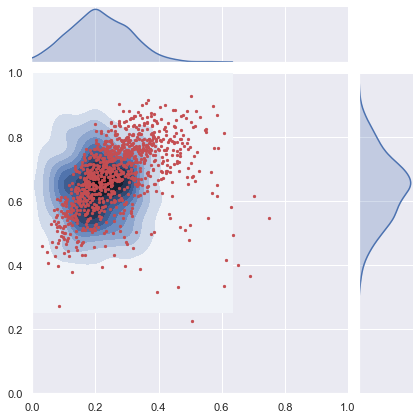

[0.1428781133841002, 0.08517948335831428]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0

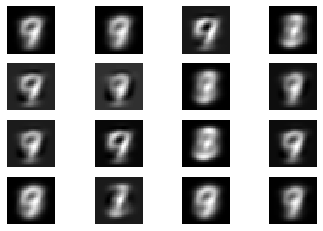

Generator Loss: 0.00014849651597327872
Discriminator Loss: 7.82925957790929
--------------------


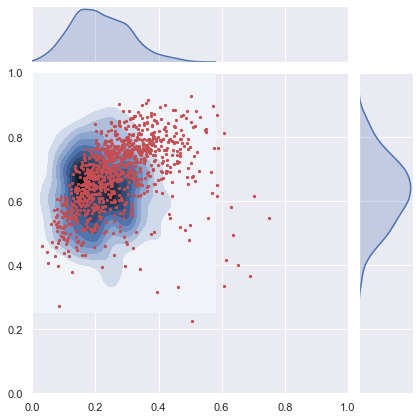

[0.12989443739412, 0.10021166114145065]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 0.1

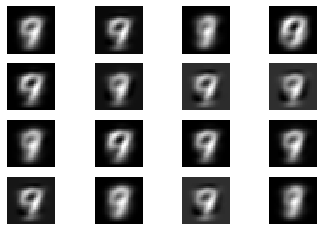

Generator Loss: 0.00010311836129888859
Discriminator Loss: 7.82725114180535
--------------------


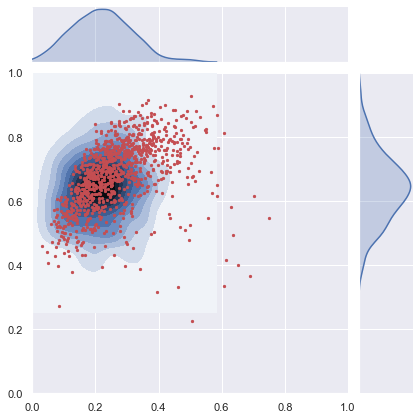

[0.12740003136985165, 0.10351910940200369]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

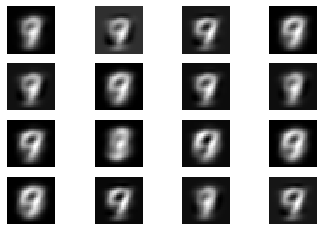

Generator Loss: 0.00013199011409421754
Discriminator Loss: 7.8284557193451025
--------------------


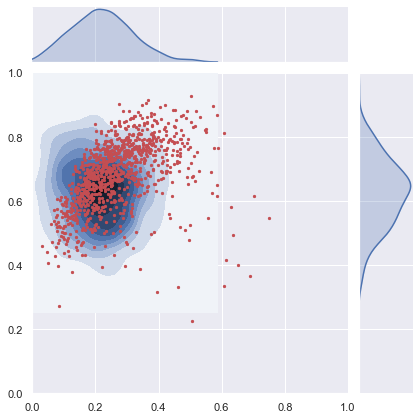

[0.10747786966870726, 0.11384460905490715]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

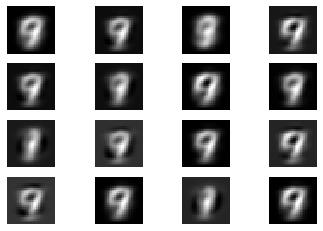

Generator Loss: 0.00011548866727423726
Discriminator Loss: 7.826849938189136
--------------------


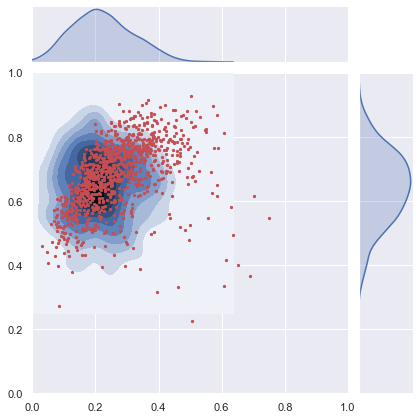

[0.10941507351770371, 0.06386097689086957]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

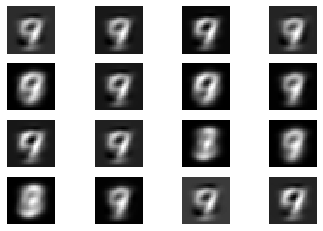

Generator Loss: 0.00011136743258186233
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


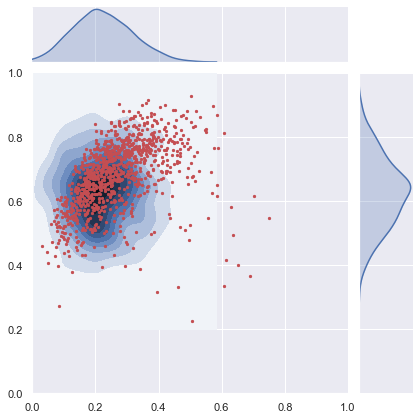

[0.11560552214910769, 0.13401296099751048]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

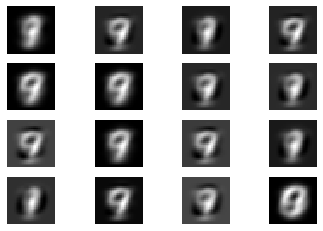

Generator Loss: 9.074475106950712e-05
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


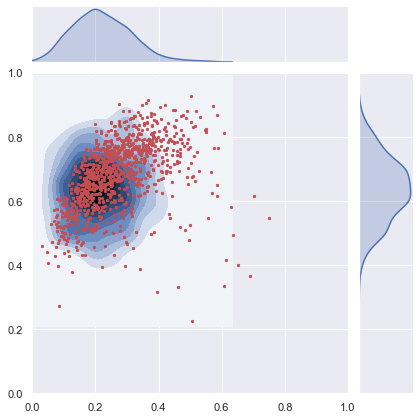

[0.11600539797297037, 0.08515990166638311]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

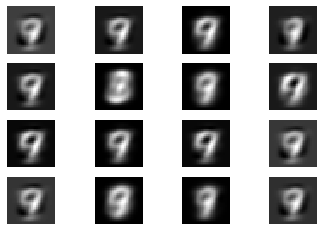

Generator Loss: 8.249402765951698e-05
Discriminator Loss: inf
--------------------


C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


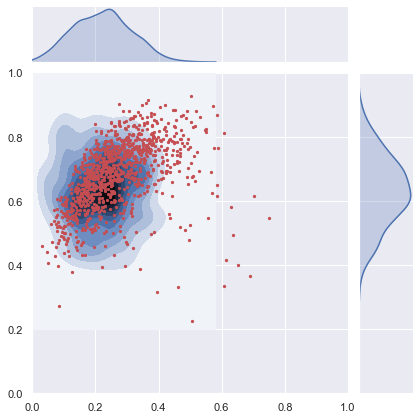

[0.13565775870419075, 0.10127324559298351]
[0.35876042275548803, 0.48458239860951724, 0.4741611670829733, 0.4366524724020069, 0.3902478289795802, 0.37233938601986905, 0.34477355951578964, 0.3213827304803119, 0.3051386836641224, 0.29406955186661143, 0.27240349668258484, 0.2963433699461292, 0.2669155127769342, 0.24578688414764502, 0.26119063486203115, 0.22421118573452664, 0.23966806347300962, 0.21013008917241396, 0.19861668774521743, 0.21043701900237724, 0.22288882465195525, 0.19825007668169742, 0.19823749404445673, 0.19593047484535062, 0.18573769829072279, 0.17488842233360413, 0.1674125754444981, 0.16553731393036575, 0.1863394413764743, 0.17269667426088303, 0.18718224705502215, 0.16098624557899882, 0.15236534866084686, 0.13872505829356768, 0.13912800401428582, 0.14642743330195035, 0.14529705289512457, 0.14252105603461296, 0.1217145135307377, 0.11680153833315193, 0.11562611968344244, 0.12304947257423995, 0.13827076908738345, 0.11695261188331567, 0.13552566153151152, 0.12403128339146521, 

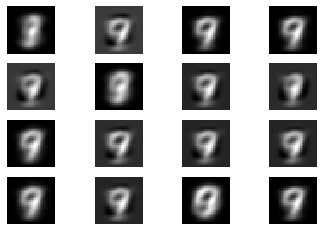

C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
C:\Users\samue\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [91]:
q=5 # Set it to dimensionality of data *n 2 +. 1
c=1
#file_name = input("Input File Name to store Results")
tracked_kl_div_1 = []
tracked_kl_div_2 = []
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
train_var = init_random_variables(q-1,layer_style)

tracked_d_loss = []
gradients = []
learning_rate=0.01
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 10
df = [0,0]
print('Starting Training')
print('-'*20)

for epoch in np.arange(1,100):
    par_shift = 0.5*np.pi*np.sqrt(1/(epoch+1))
    # ------------------------------------------------------------------------------------------
    # This section is the discriminator training section
    # Each data point is tested against a random number, of which it decidesa wheter to 
    # Train against discerning between fake or real 
    # This causes "unstable" loss functions, but not very "unstable". Just slightly inconsistent
    # ------------------------------------------------------------------------------------------
    counter = 0
    for _ in range(1):
        for key,value in train_var.items():
            if str(q//2 + 1 ) in key:
                break
            for key_value in range(len(value)):
                forward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)),1,None)
                backward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)),1,None)
                df = 0.5*(forward_diff-backward_diff)
                if abs(df)>1:
                    df = df/abs(df)
                #train_var[key][key_value] -= df*learning_rate/10
    for index,point in enumerate(pca_data_rot):
        df = [0,0]
        gradients = []
        loss= [0,0]
        #Training the Discriminator:
        for key,value in train_var.items():
            if str(q//2 + 1) in key:
                break
            for key_value in range(len(value)):
                #TRAIN ON REAL DATA
                # BETIS HERE
                # _________
                forward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=True)),0,None)
                backward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=False)),0,None)
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= learning_rate*df
        loss[0] += cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=False,fwd_diff=False)),0,None)
        loss[1] += 1
    loss_g = [0,0]
    # ------------------------------------------------------------------------------------------
    # This section is the generator training section
    # The discriminator just looks to fool the state we learnt above 
    # This means that instead of learning 10000 times, we could up the learning rate and just learn a few more times
    # We dont want it to be too large so it spins around the qubits state
    # ------------------------------------------------------------------------------------------
    #Train the generator now as much as we trained the Disc
    for _ in range(len(pca_data_rot)//10):
        gen_params=True
        for key,value in train_var.items():
            if str(q//2 + 1) not in key and gen_params:
                #print(f"{key} is not a GAN parameter")
                continue
            else: 
                gen_params = False
            for key_value in range(len(value)):
                #TRAIN ON FAKE DATA
                forward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)))
                backward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)))
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= df*learning_rate*2.5
        loss_g[0] += generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)))
        loss_g[1] +=1
    print(f"Generator Loss: {loss_g[0]/loss_g[1]}")
    tracked_g_loss.append(loss_g[0]/loss_g[1])
    loss_qgan = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)),1,None) 
    t_loss = loss_qgan + (loss[0]/loss[1])
    #t_loss = loss[0]/loss[1]
    tracked_loss_d_to_real.append(loss[0]/loss[1])
    tracked_loss_d_to_g.append(loss_qgan)
    print(f"Discriminator Loss: {t_loss}")
    tracked_d_loss.append(t_loss)
    print("-"*20)
    data = []
    circ = disc_fake_training_circuit(train_var,point,key,key_value,Sample=True)
    n_results = q//2
    for _ in range(500):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
        #print(np.mean(generate_kl_divergence_hist(pca_data, np.array(data))))
    data = np.array(data)
    try:
        graph = sns.jointplot(x=data[:,0],y=data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
        graph.x = pca_data[:,0]
        graph.y = pca_data[:,1]
        graph.plot_joint(plt.scatter, marker='o', c='r', s=5)
        plt.show()
    except:
        pass
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-distribution".format(epoch))
    dim1_kl_div = generate_kl_divergence_hist(pca_data, data)
    print(dim1_kl_div)
    tracked_kl_div_1.append(np.mean(np.array(dim1_kl_div)))
    print(tracked_kl_div_1)
    # For accurate KL Div we need to usue higher shots
    data = []
    for _ in range(16):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    new_info = descale_points(data[:16])
    new_info = new_info.reshape(new_info.shape[0],28,28)
    print(f"Epoch {epoch} Generated Images")
    for i in range(new_info.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_info[i, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-images".format(epoch))
    plt.show()
    with open('new_qgan_results_mnis_epoch_ICLR_{}.txt'.format(epoch), 'w') as file:
        file.write("Tracked KL Divergence\n")
        file.write(str(tracked_kl_div_1)+"\n")
        file.write("Loss Of Generator\n")
        file.write(str(tracked_g_loss)+"\n")
        file.write("Loss Of Discriminator\n")
        file.write(str(tracked_d_loss)+"\n")
    save_variables(train_var,epoch)

In [78]:
train_var

{'1': [0.7583314538353588],
 '1,2': [-0.4409412720203749],
 '1--2': [0.9398656421045786],
 '2': [0.4055456060852219],
 '2,3': [2.4394057943315506],
 '2--3': [0.5912893955176854],
 '3': [3.233408406129141],
 '3,4': [2.8064065559306153],
 '3--4': [2.0313926678857435],
 '4': [-2.208932069493722]}

In [101]:
# TO LOAD SOME VARs
# DONT RUN UNLESS YOU LOADING VARS.
epoch=65
with open(f"Epoch-{epoch}-Variables-numbers-9") as file:
    variables = file.readline()
    train_var = eval(variables)
q=5 # Set it to dimensionality of data *n 2 +. 1
c=1
#file_name = input("Input File Name to store Results")
tracked_kl_div_1 = []
tracked_kl_div_2 = []
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
#train_var = init_random_variables(q-1,layer_style)
data = []
tracked_d_loss = []
gradients = []
learning_rate=0.01
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 10
df = [0,0]
print('Starting Training')
print('-'*20)
circ = disc_fake_training_circuit(train_var,point,key,key_value,Sample=True)
n_results = q//2
for _ in range(500):
    job = execute(circ, backend, shots=20)
    results = job.result().get_counts(circ)
    bins = [[0,0] for _ in range(n_results)]
    for key,value in results.items():
        for i in range(n_results):
            if key[-i-1]== '1':
                bins[i][0] += value
            bins[i][1] += value
    for i,pair in enumerate(bins):
        bins[i]= pair[0]/pair[1]
    data.append(bins)
    #print(np.mean(generate_kl_divergence_hist(pca_data, np.array(data))))
data = np.array(data)


Starting Training
--------------------


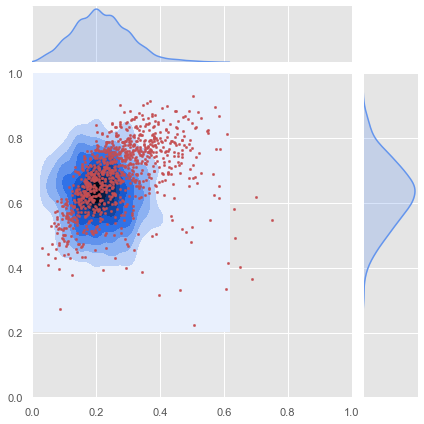

In [102]:
plt.style.use("ggplot")
graph = sns.jointplot(x=data[:,0],y=data[:,1],kind="kde",color='cornflowerblue',ylim=(0,1),xlim=(0,1))
graph.x = pca_data[:,0]
graph.y = pca_data[:,1]
graph.plot_joint(plt.scatter, marker='o', c='r', s=5)
plt.savefig("9_100_epochs.png")

In [103]:
print(disc_fake_training_circuit(train_var,point,key,key_value,Sample=True))

          ┌───┐                                              
q_0: ─────┤ H ├──────────────────────────────────────────────
     ┌────┴───┴────┐┌─────────────────┐                      
q_1: ┤ RY(0.97536) ├┤0                ├───────■──────────────
     └┬────────────┤│  RYY(-0.098191) │┌──────┴───────┐      
q_2: ─┤ RY(1.8435) ├┤1                ├┤ RY(0.040139) ├──────
     ┌┴────────────┤└┬────────────────┤└──────────────┘┌─┐   
q_3: ┤ RY(0.97268) ├─┤0               ├───────■────────┤M├───
     └┬────────────┤ │  RYY(-0.10099) │┌──────┴───────┐└╥┘┌─┐
q_4: ─┤ RY(1.8291) ├─┤1               ├┤ RY(0.085168) ├─╫─┤M├
      └────────────┘ └────────────────┘└──────────────┘ ║ └╥┘
c: 2/═══════════════════════════════════════════════════╩══╩═
                                                        0  1 


In [8]:
# Evaluation section
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_16_melbourne')
#backend = Aer.get_backend('qasm_simulator')
q=9 # Set it to dimensionality of data *n 2 +. 1
c=1
#file_name = input("Input File Name to store Results")
tracked_kl_div_1 = []
tracked_kl_div_2 = []
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
train_var = init_random_variables(q-1,layer_style)

tracked_d_loss = []
gradients = []
learning_rate=0.03 
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 10
df = [0,0]
print('Starting Training')
print('-'*20)

for epoch in np.arange(1,100):
    par_shift = 0.5*np.pi*np.sqrt(1/(epoch+1))
    print("-"*20)
    data = []
    circ = disc_fake_training_circuit(train_var,None,None,None,Sample=True)
    n_results = q//2
    for _ in range(500):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
        print(np.mean(generate_kl_divergence_hist(pca_data, np.array(data))))
    data = np.array(data)
    try:
        graph = sns.jointplot(x=data[:,0],y=data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
        graph.x = pca_data[:,0]
        graph.y = pca_data[:,1]
        graph.plot_joint(plt.scatter, marker='o', c='r', s=5)
        plt.show()
    except:
        pass
    dim1_kl_div = generate_kl_divergence_hist(pca_data, data)
    print(dim1_kl_div)
    tracked_kl_div_1.append(np.mean(np.array(dim1_kl_div)))
    print(tracked_kl_div_1)
    # For accurate KL Div we need to usue higher shots
    data = []
    for _ in range(16):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    new_info = descale_points(data[:16])
    new_info = new_info.reshape(new_info.shape[0],28,28)
    print(f"Epoch {epoch} Generated Images")
    for i in range(new_info.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_info[i, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-images".format(epoch))
    plt.show()
    with open('qgan_results_mnis_epoch_ICLR_{}.txt'.format(epoch), 'w') as file:
        file.write("Tracked KL Divergence\n")
        file.write(str(tracked_kl_div_1)+"\n")
        file.write("Loss Of Generator\n")
        file.write(str(tracked_g_loss)+"\n")
        file.write("Loss Of Discriminator\n")
        file.write(str(tracked_d_loss)+"\n")
    save_variables(train_var,epoch)

C:\Users\samue\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-03-01 18:36:58,975: Credentials are already in use. The existing account in the session will be replaced.


NameError: name 'init_random_variables' is not defined

Text(0, 0.5, 'Hellinger Distance')

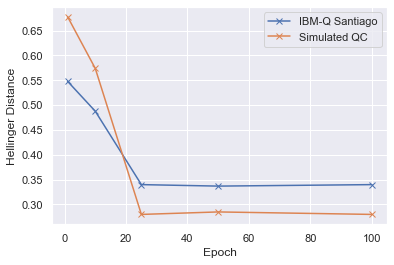

In [43]:
real_qc = [0.548,0.4878,0.34,0.337,0.34]
sim_qc = [0.678,0.574,0.28,0.285,0.28]
epochs= [1,10,25,50,100]
plt.plot(epochs,real_qc,'-x',label='IBM-Q Santiago')
plt.plot(epochs,sim_qc,'-x',label='Simulated QC')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Hellinger Distance")

Epoch 99 Generated Images


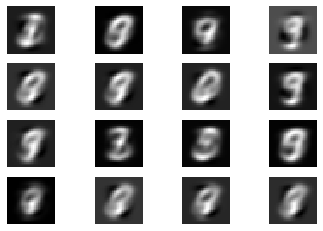

Epoch 99 Generated Images


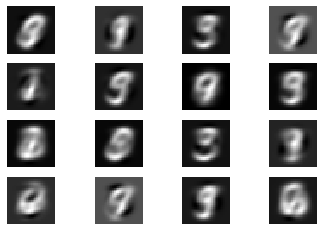

Epoch 99 Generated Images


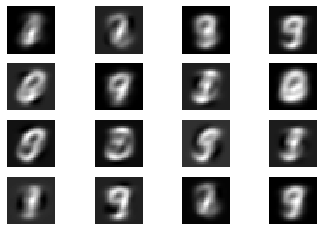

Epoch 99 Generated Images


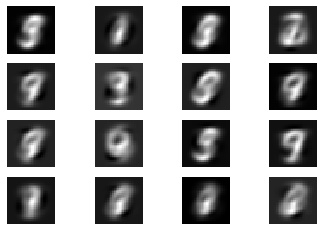

Epoch 99 Generated Images


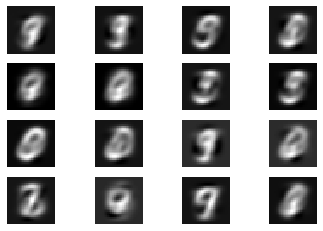

Epoch 99 Generated Images


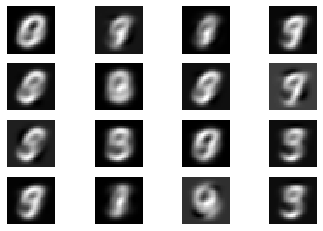

Epoch 99 Generated Images


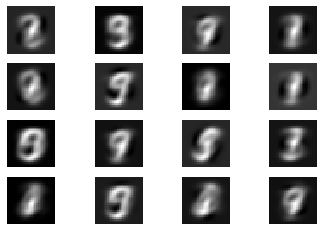

Epoch 99 Generated Images


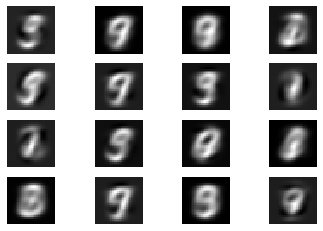

Epoch 99 Generated Images


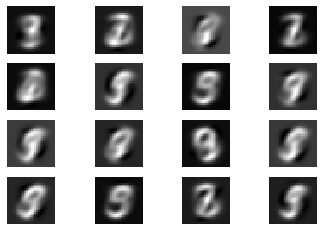

Epoch 99 Generated Images


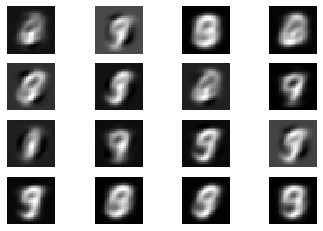

Epoch 99 Generated Images


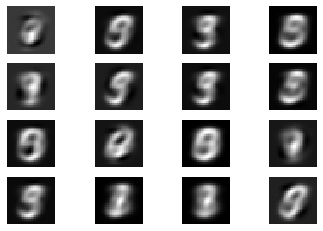

Epoch 99 Generated Images


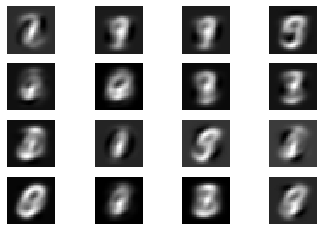

Epoch 99 Generated Images


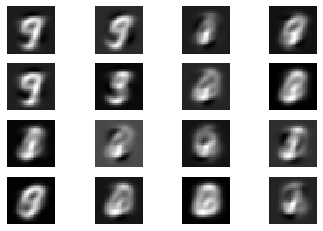

Epoch 99 Generated Images


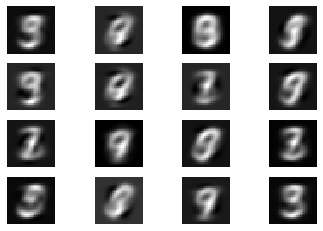

Epoch 99 Generated Images


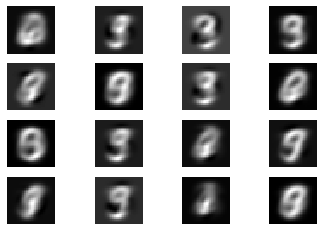

Epoch 99 Generated Images


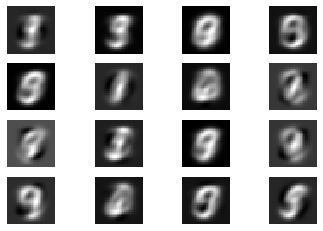

Epoch 99 Generated Images


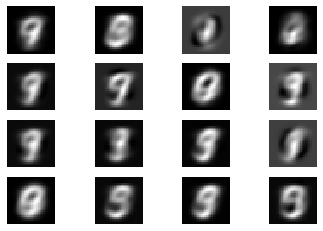

Epoch 99 Generated Images


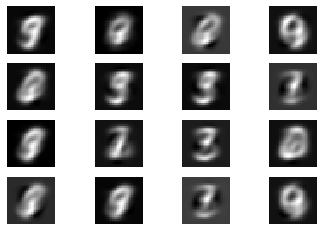

Epoch 99 Generated Images


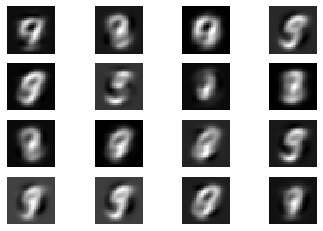

Epoch 99 Generated Images


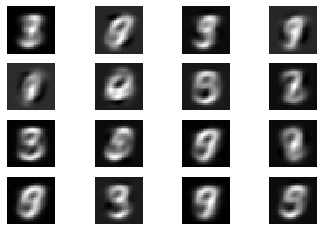

In [66]:
for _ in range(20):
    data = []
    for _ in range(16):
        job = execute(circ, backend, shots=15)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)

    new_info = descale_points(data[:16])
    new_info = new_info.reshape(new_info.shape[0],28,28)
    print(f"Epoch {epoch} Generated Images")
    for i in range(new_info.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_info[i, :, :], cmap='gray')
        plt.axis('off')
    plt.show()